In [1]:
# Basic
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import pinv2
from tqdm import tqdm
import pandas as pd
import itertools

# For Dataset
from collections import deque, namedtuple
import random

# For solvers
from qpsolvers import solve_qp
from scipy.integrate import solve_ivp
from casadi import *
import casadi

# For estimators
from torch import nn
import torch
import torch.nn.functional as F




In [2]:
from utils.system import AAC
from utils.controller2 import *
from utils.dataset import Dataset
from utils.estimator2 import *
from utils.normalizer import *
from utils.functions import *


# Parameters

In [3]:
dt = 0.01
simTime = 10

# Real parameters
v_lead = 20
v_des = 24
m  = 1650.0
g = 9.81

# 
f0 = 0.1
f1 = 5
f2 = 0.25


c_a = 0.3
c_d = 0.3
Th = 1.8

# Nominal parameters
f0_nom = 10*f0
f1_nom = 10*f1
f2_nom = 10*f2

p_slack = 2e-2
clf_rate = 5
cbf_rate = 5.

# Initial state
p0 = 0
v0 = 20
z0 = 40

x = [p0, v0 ,z0]




In [4]:
def c2l(d):
    if type(d) == float or type(d) == int or type(d) == np.float64:
        return [d]
    if type(d) == list:
        return d
    if type(d) == np.ndarray:
        return d.tolist()
    

## Main

In [9]:
d = Dataset(('x', 'k', 'dhe_real'))

aac = AAC(m, c_d, f0, f1, f2, v_lead)

norm_x = WelfordNormalizerOne((3,))
norm_u = WelfordNormalizerOne((1,))
norm_dhe = WelfordNormalizerOne((1,))

normalizer = {'x':norm_x, 'u':norm_u, 'dhe':norm_dhe}


cont = LCBF(0.8*m, c_a, c_d, f0_nom, f1_nom, f2_nom, v_lead, v_des, Th, clf_rate, cbf_rate, p_slack)


weights = 0.2


derivator = Derivator(dt)


# PID control reference
x_dim = 3
u_dim = 1

kp = np.array([[0, 1.0e3, 0]])/50000
kd = np.array([[0, 0.1, 0]])/100
ki = np.array([[0, 1.0e3, 0]])/50000

pid = PID(x_dim, u_dim, kp, kd, ki, dt)

# SGD: lr + z0 + v0 + func
lr =  [1e-4]#[1e-2, 1e-3, 1e-4, 1e-5]
z0s = [38]#[30, 34, 38]
v0s = [20]
funcs = [sin]


data_dir = 'data/sgd'

cases = len(list(itertools.product(lr, z0s, v0s, funcs)))
pbar = tqdm(total=cases*simTime/dt)

for lr, z0, v0, func in itertools.product(lr, z0s, v0s, funcs):
    x = [0, v0, z0]
    fn = "{}_{}_{}_{}.csv".format(lr, z0, v0, func.__name__)
    
    # Database
    column_names = ['p', 'v', 'z', 'u','u_ref','V','h','dhe_real','dhe','slack']
    df = pd.DataFrame(columns=column_names,dtype=object)

    # save file .csv
    path = os.path.join(data_dir, fn)
    df.to_csv(path, index=False)
    
    # Estimator
    estimator = NN_affine(3,1, lr)
    e_f_opt,e_g_opt = torch.optim.Adam(estimator.e_f.model.parameters(), lr = lr), torch.optim.Adam(estimator.e_g.model.parameters(), lr = lr) 
    
    
    # Normalizer
    norm_x = WelfordNormalizerOne((3,))
    norm_u = WelfordNormalizerOne((1,))
    norm_dhe = WelfordNormalizerOne((1,))

    normalizer = {'x':norm_x, 'u':norm_u, 'dhe':norm_dhe}

    for t in np.arange(0, simTime, dt): #simTime
        pbar.update(1)
        # Get reference control
        e = np.array([[0], [v_des], [0]]) - np.expand_dims(x, axis = 1)
        u_ref = pid.update(e) #f0_nom * v**2 + f1_nom * v + f2_nom
        u_ref = u_ref[0,0]

        unct = func(t)
        aac.v_lead = v_lead + unct  # lead_vehicle
        
        # Control Input
        k, slack_sol, V, dV, h, dh, dhe, dS = cont.compute_controller(x, u_ref, estimator, weights, t, normalizer) 

        # One step propagation in the system
        x_n = aac.update(x, k, t, dt)

        dh_real = derivator.update(h)
        dhe_real = dh_real - dh

        
        dhe_real_norm = normalizer['dhe'].update(dhe_real)
        x_norm = normalizer['x'].update(x)
        k_norm = normalizer['u'].update(k)

        d.update(x_norm, k_norm[0].item(), dhe_real_norm)
        #d.update(x, k, dhe_real)


        row = c2l(x) + c2l(k) + c2l(u_ref) + c2l(V) + c2l(h) + c2l(dhe_real) + c2l(dhe) + c2l(slack_sol)
        df_row = pd.DataFrame(dict(zip(column_names, row)), index = [0])
        
        df.append(df_row, sort = False).to_csv(path, index=False, mode = 'a', header=False)

        x = x_n

        estimator.train(t, d)
            

pbar.close()
    
        
        



100%|██████████| 1000/1000.0 [00:14<00:00, 67.85it/s]


NameError: name 'xs_lst' is not defined

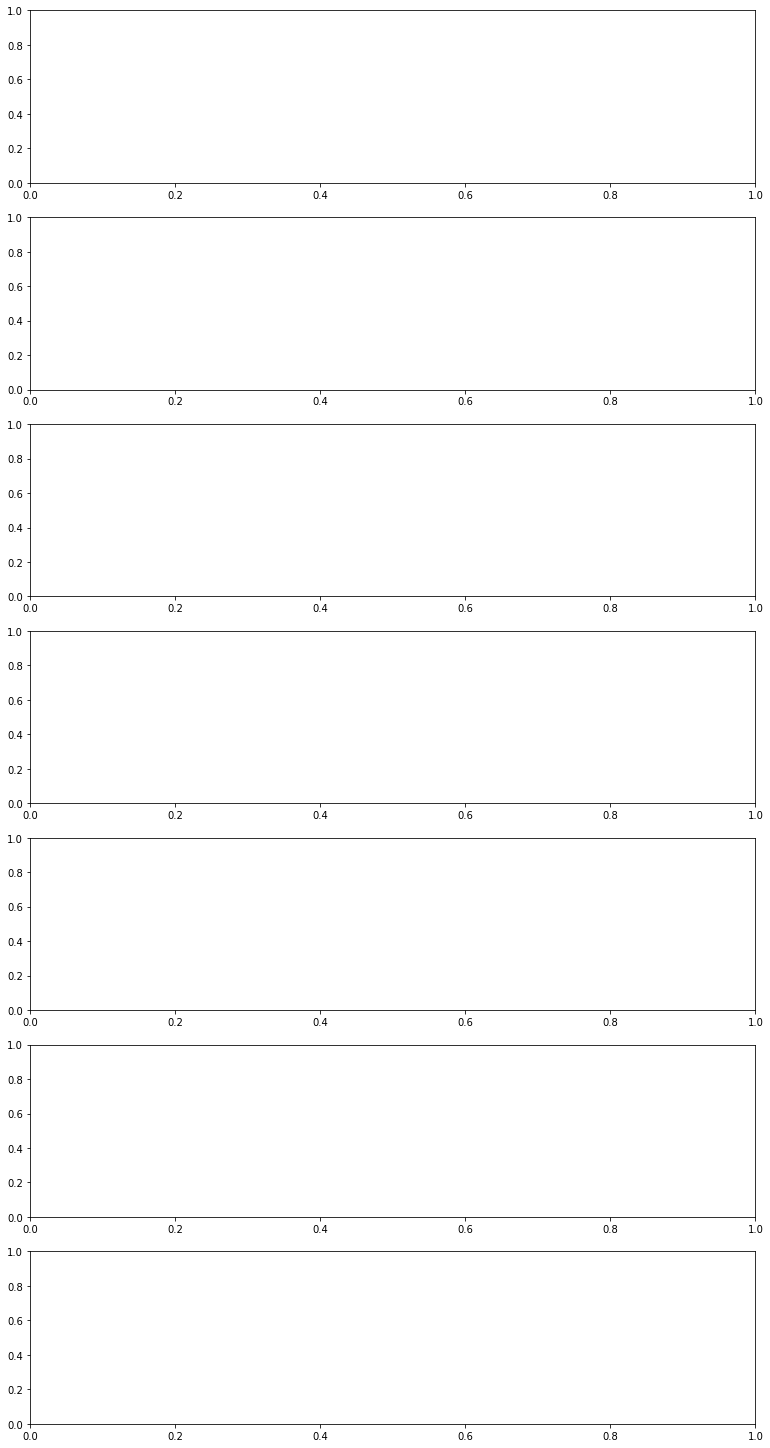

In [6]:

i = 0


f,ax = plt.subplots(7,1,figsize = (13,26))
t_lns = np.arange(0, simTime, dt)

ax[0].plot(t_lns, np.array(xs_lst)[i,:,1])
ax[0].grid(True)
ax[0].set_title('State - velocity')

ax[1].plot(t_lns,  np.array(xs_lst)[i,:,2])
ax[1].grid(True)
ax[1].set_title('State - distance')

ax[1].plot(t_lns, Th*np.array(xs_lst)[i,:,1])#  + 0.5*(np.array(x_lst)[exp,:,1] - v_ego)/c_d/g)

ax[2].plot(t_lns,  np.array(us_lst)[i,:])
ax[2].grid(True)
ax[2].set_title('Control input')


ax[3].plot(t_lns, np.array(slacks_lst)[i,:])
ax[3].grid(True)
ax[3].set_title('Slack variable')


ax[4].plot(t_lns, np.array(hs_lst)[i,:])
ax[4].grid(True)
ax[4].set_title('CBF')

ax[5].plot(t_lns, np.array(Vs_lst)[i,:])
ax[5].grid(True)
ax[5].set_title('CLF')

ax[6].plot(t_lns[1:], np.array(dhes_lst)[i, 1:])
ax[6].plot(t_lns[1:], np.array(dhe_reals_lst)[i,1:])
ax[6].grid(True)
ax[6].set_title('$dh_{error}$')


ax[6].set_ylim([-10,10])
ax[6].legend(['$dhe_{est}$','$dhe_{real}$'])

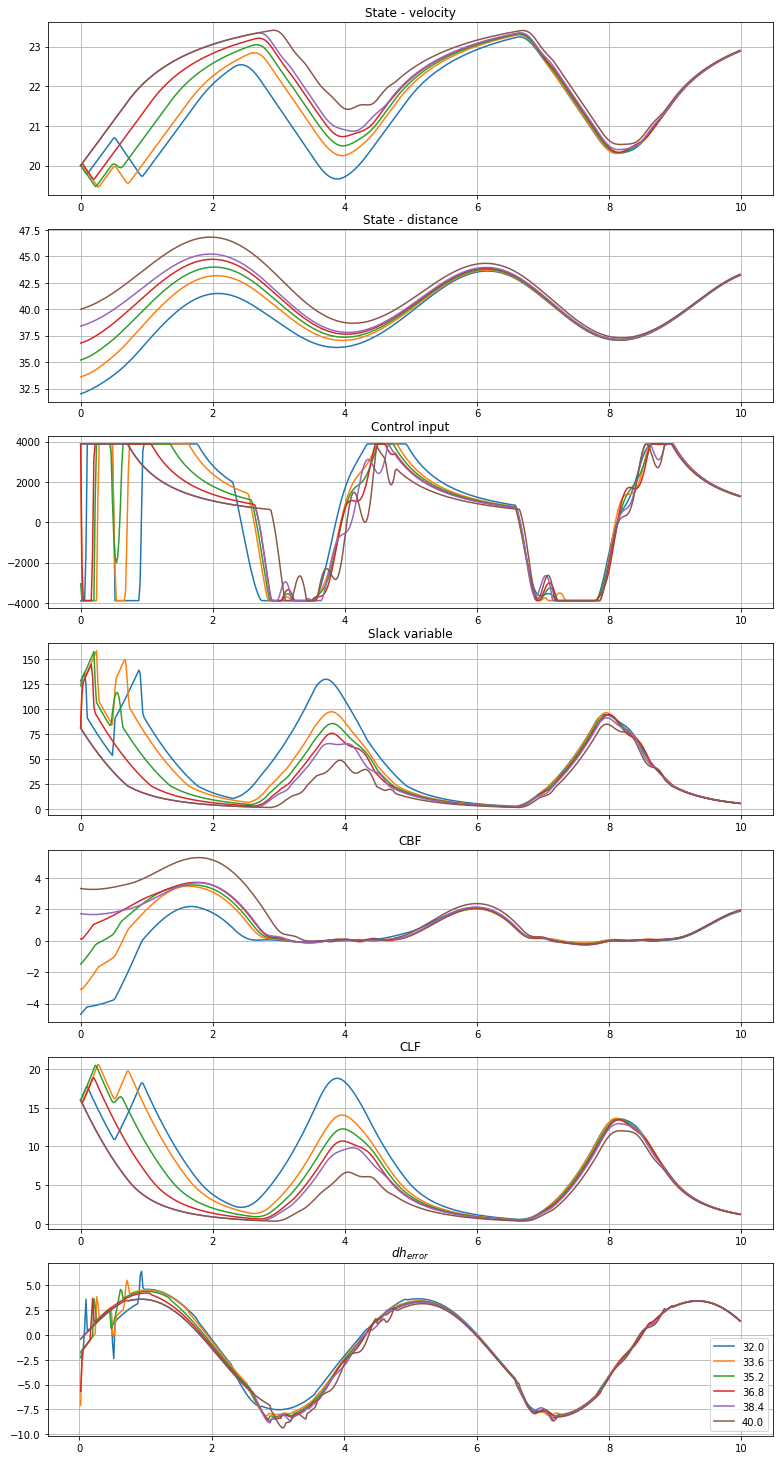

In [17]:
f,ax = plt.subplots(7,1,figsize = (13,26))
t_lns = np.arange(0, simTime, dt)

for i in range(laps):
    ax[0].plot(t_lns, np.array(xs_lst)[i,:,1])
    ax[0].grid(True)
    ax[0].set_title('State - velocity')
    
    ax[1].plot(t_lns,  np.array(xs_lst)[i,:,2])
    ax[1].grid(True)
    ax[1].set_title('State - distance')
    
    #ax[1].plot(t_lns, Th*np.array(xs)[:,1])#  + 0.5*(np.array(x_lst)[exp,:,1] - v_ego)/c_d/g)

    ax[2].plot(t_lns,  np.array(us_lst)[i,:])
    ax[2].grid(True)
    ax[2].set_title('Control input')
    

    ax[3].plot(t_lns, np.array(slacks_lst)[i,:])
    ax[3].grid(True)
    ax[3].set_title('Slack variable')
    

    ax[4].plot(t_lns, np.array(hs_lst)[i,:])
    ax[4].grid(True)
    ax[4].set_title('CBF')

    ax[5].plot(t_lns, np.array(Vs_lst)[i,:])
    ax[5].grid(True)
    ax[5].set_title('CLF')

    #ax[6].plot(t_lns[1:], np.array(dhes_lst)[i, 1:])
    ax[6].plot(t_lns[1:], np.array(dhe_reals_lst)[i,1:])
    ax[6].grid(True)
    ax[6].set_title('$dh_{error}$')
    

    #ax[6].set_ylim([-10,10])
    ax[6].legend(dlst)


### No training

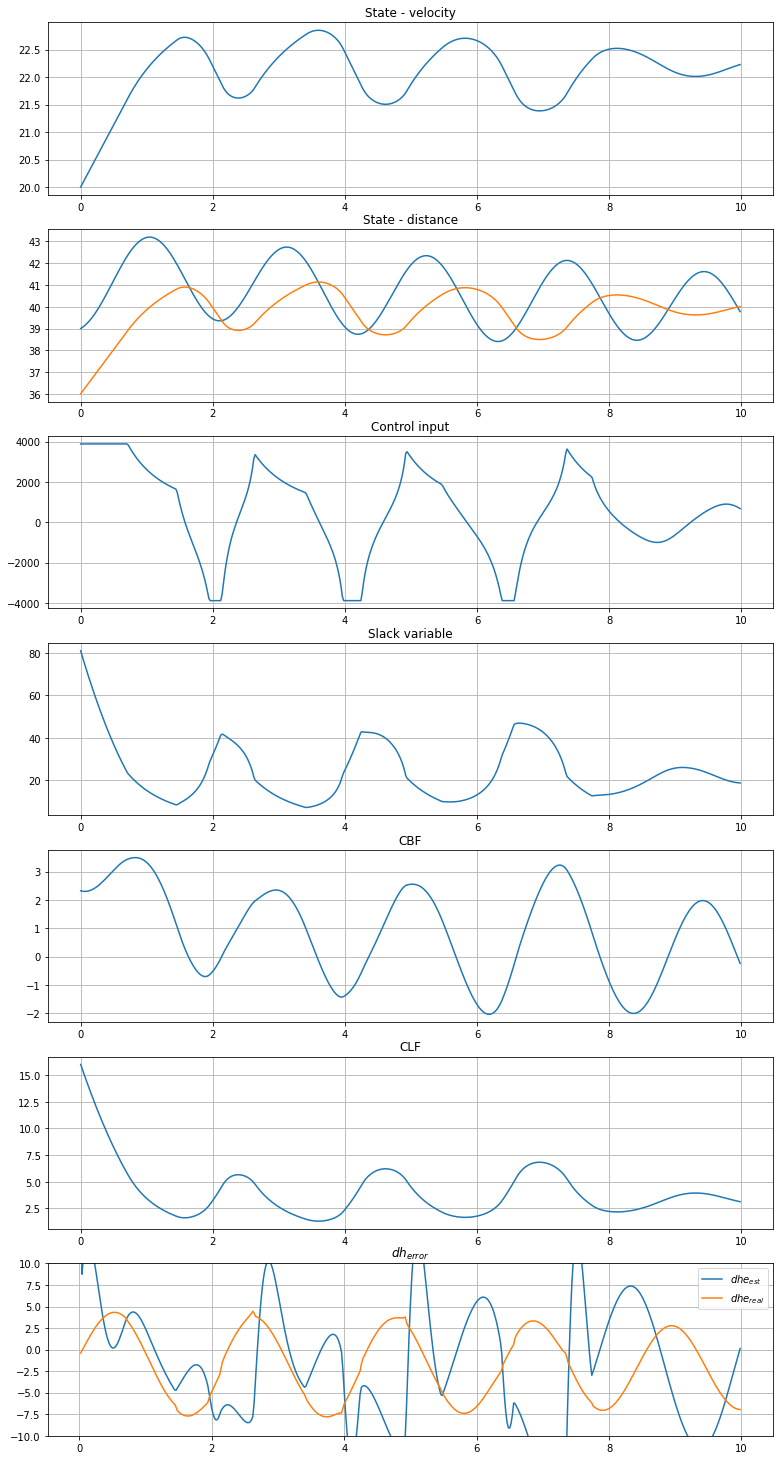

In [12]:
f,ax = plt.subplots(7,1,figsize = (13,26))
t_lns = np.arange(0, simTime, dt)

ax[0].plot(t_lns, np.array(xs)[:,1])
ax[0].grid(True)
ax[0].set_title('State - velocity')
 
ax[1].plot(t_lns,  np.array(xs)[:,2])
ax[1].grid(True)
ax[1].set_title('State - distance')
 
ax[1].plot(t_lns, Th*np.array(xs)[:,1])#  + 0.5*(np.array(x_lst)[exp,:,1] - v_ego)/c_d/g)

ax[2].plot(t_lns,  np.array(us))
ax[2].grid(True)
ax[2].set_title('Control input')
 

ax[3].plot(t_lns, np.array(slacks))
ax[3].grid(True)
ax[3].set_title('Slack variable')
 

ax[4].plot(t_lns, hs)
ax[4].grid(True)
ax[4].set_title('CBF')

ax[5].plot(t_lns, Vs)
ax[5].grid(True)
ax[5].set_title('CLF')

ax[6].plot(t_lns[1:], dhes[1:])
ax[6].plot(t_lns[1:], dhe_reals[1:])
ax[6].grid(True)
ax[6].set_title('$dh_{error}$')
 

ax[6].set_ylim([-10,10])
ax[6].legend(['$dhe_{est}$','$dhe_{real}$'])
